In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sessions = pd.read_csv('./sessions.csv')
iaps = pd.read_csv('./iaps.csv')
spendevents = pd.read_csv('./spendevents.csv')
users = pd.read_csv('./users.csv')

# 1. Sessions

### a. Time features

In [5]:
sessions['count_time'] =1
sessions['ts_c'] = pd.to_datetime(sessions['ts'], infer_datetime_format=True)
sessions['ts_dayofweek'] = sessions['ts_c'].apply(lambda x: x.dayofweek)
sessions['ts_dayofyear'] = sessions['ts_c'].apply(lambda x: x.dayofyear)
sessions['ts_weekofyear'] = sessions['ts_c'].apply(lambda x: x.weekofyear)
sessions['ts_hour'] = sessions['ts_c'].apply(lambda x: x.hour)
sessions.head(1)

In [6]:
sessions_sum = sessions.groupby('udid')['date'].agg([len]).reset_index()
sessions_sum['total_active_sessions'] = sessions_sum['len'].\
apply(lambda x: 'one time user'if x<2 else 'less than 10 times' if x>=2 and x<11 else '11-30 times' \
      if x >=11 and x <30 else 'more than 30 times' )

In [8]:
sessions_sum['total_active_sessions'].value_counts()

less than 10 times    8959
more than 30 times    5627
11-30 times           4255
one time user         3703
Name: total_active_sessions, dtype: int64

### b. session features -frequency &active sessions

In [223]:
sessions_feature.head(1)

,udid,len,total_active_sessions,amin,amax,length,frequency,frequency_type,length_type
0,0001098a82ba4bd5b552faf5ad92b93c,44,more than 30 times,215,246,31,1.419355,active 0.6-3 times a day,24 to 60 days


In [45]:
sessions_sum['total_active_sessions'].value_counts()

less than 10 times    8959
more than 30 times    5627
11-30 times           4255
one time user         3703
Name: total_active_sessions, dtype: int64

In [9]:
sessions_sum3 = sessions.groupby('udid')['ts_dayofyear'].agg([np.min,np.max]).reset_index()
sessions_sum3['amax'] = pd.to_numeric(sessions_sum3.amax, errors='coerce')
sessions_sum3['amin'] = pd.to_numeric(sessions_sum3.amin, errors='coerce')
sessions_sum3['length'] = sessions_sum3[['amax','amin']].apply(lambda x: x[0]-x[1], axis =1)
sessions_feature = pd.merge(sessions_sum, sessions_sum3, how = 'left', on = 'udid')
sessions_feature['frequency'] = sessions_feature[['len','length']].apply(lambda x: x[0]/x[1] if x[1] !=0 else 0.01, axis =1)
sessions_feature.head(2)

In [12]:
sessions_feature['frequency_type'] = sessions_feature['frequency']\
.apply(lambda x: 'inactive' if x<=0.02 else '0.02-0.6 times a day' \
       if x>0.02 and x <0.6 else 'active 0.6-3 times a day'if x>=0.6 and x<3 \
       else 'more than 3 times a day')
sessions_feature['length_type'] = sessions_feature['length']\
.apply(lambda x: 'one day' if x<=1 else 'less than 3 days' if x>1 and x<3 else '3 to 24 days'\
       if x>=3 and x<24 else '24 to 60 days')

### c. the week trend of user sessions

From week31 to week40 are the user sessions are declining in general

In [221]:
pivot_w = pd.pivot_table(sessions,index=["udid"],\
                               values=["count_time"],columns=["ts_weekofyear"],\
                               aggfunc=[len],fill_value=0,margins=True)
pivot_w = pd.DataFrame(pivot_w.to_records())
pivot_w.columns = [i.replace("('len', 'count_time',", "week").replace(")", "") \
for i in pivot_w.columns]
agg_w = pivot_w.sum(axis=0)
agg_w = agg_w.drop('udid').drop("week 'All'")
#agg_w.plot.bar()

### d. the hour trend of the session distribution

In [222]:
pivot_h = pd.pivot_table(sessions,index=["udid"],\
                               values=["count_time"],columns=["ts_hour"],\
                               aggfunc=[len],fill_value=0,margins=True)
pivot_h = pd.DataFrame(pivot_h.to_records())
pivot_h.columns = [i.replace("('len', 'count_time',", "hour").replace(")", "") \
for i in pivot_h.columns]
pivot_h_sum = pivot_h.sum(axis=0).drop('udid').drop("hour 'All'")
#pivot_h_sum.plot.bar()

### e. Graphic: sessions by week and by hour

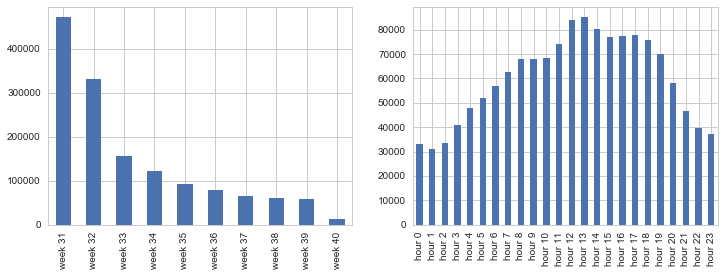

In [220]:
fig, ax = plt.subplots(1,2, figsize =[12,4])
agg_w.plot.bar(ax=ax[0])
pivot_h_sum.plot.bar(ax = ax[1])

# 2. iaps

### a. iaps time features

In [23]:
iaps['ts_iaps'] = pd.to_datetime(sessions['ts'], infer_datetime_format=True)
iaps['ts_dayofweek'] = iaps['ts_iaps'].apply(lambda x: x.dayofweek)
iaps['ts_dayofyear'] = iaps['ts_iaps'].apply(lambda x: x.dayofyear)
iaps['ts_weekofyear'] = iaps['ts_iaps'].apply(lambda x: x.weekofyear)
iaps['ts_hour'] = iaps['ts_iaps'].apply(lambda x: x.hour)
iaps['count_times'] = 1
#iaps_sort = iaps.sort_values(['udid', 'ts_iaps'], ascending=[True, True])

In [115]:
iaps.head(1)

,udid,ts,date,prod_name,prod_type,rev,ts_iaps,ts_dayofweek,ts_dayofyear,ts_weekofyear,ts_hour,count_times
0,a737cacac9b9432180f7106c248dc9dc,8/1/16 9:35,8/1/16,iap_1_diamonds_2,diamonds,140,2016-08-01 00:13:00,0,214,31,0,1


In [26]:
iaps['prod_type'].value_counts()

diamonds         4574
chapterPasses    2029
valuePack          83
Name: prod_type, dtype: int64

In [103]:
iaps_sum2= iaps.groupby('udid')['rev'].agg([len,np.sum]).reset_index()
iaps_sum2.columns = ['udid','purchase_time','purchase_sum']
iaps_sum2['purchase_amount_type'] = iaps_sum2['purchase_sum'].\
apply(lambda x: '70' if x <=70 else '70-140' if x>70 and x<=140 else '140-420'if x>140 and x<=420 \
     else '420-1050' if x>420 and x<=1050 else '>1050')

### b. iap money spent by product type

In [77]:
iap_spending = pd.pivot_table(iaps_sort,index=["udid"],\
                               values=["rev"],columns=["prod_type"],\
                               aggfunc=[np.sum],fill_value=0,margins=True)
iap_spending = pd.DataFrame(iap_spending.to_records())
iap_spending.columns = [i.replace("('sum', 'rev', '", "").replace("')", "") \
for i in iap_spending.columns]

In [224]:
agg_iap_spending = iap_spending.sum(axis=0)
agg_iap_spending= agg_iap_spending.drop('udid').drop("All")
#agg_iap_spending.plot.bar()

### c. the week trend of user in-app-purchase distribution (there is only three weeks of iap data!)

In [34]:
iaps_w = pd.pivot_table(iaps,index=["udid"],\
                               values=["rev"],columns=["ts_weekofyear"],\
                               aggfunc=[np.sum],fill_value=0,margins=True)
iaps_w = pd.DataFrame(iaps_w.to_records())
iaps_w.columns = [i.replace("('sum', 'rev',", "week").replace(")", "") \
for i in iaps_w.columns]

In [206]:
iaps_w.head(1)

,udid,week 31,week 32,week 33,week 'All'
0,0002c90acb1c4c93ac55723d690642e1,140.0,0.0,0.0,140.0


In [226]:
agg_iap_w = iaps_w.sum(axis=0)
agg_iap_w= agg_iap_w.drop('udid')
agg_iap_w= agg_iap_w.drop("week 'All'")
#agg_iap_w.plot.bar()

key finding: the in-app-purchase behavior drops significantly in the second week and the third week, and no users spend money after three weeks duration of the game.

### c. iap behavior - how many times a user spend money?

In [241]:
iap_sum1 = iaps.groupby('udid')['rev'].agg([len, np.sum,np.max,np.min]).reset_index()
iap_sum1.columns = ['udid','iap_times_spending','iap_value_sum','iap_max','iap_min']
#iap_sum1['len'].value_counts().plot(kind ='barh')

In [242]:
iap_sum1.head(1)

,udid,iap_times_spending,iap_value_sum,iap_max,iap_min
0,0002c90acb1c4c93ac55723d690642e1,1,140,140,140


In [231]:
iap_sum2 = pd.pivot_table(iaps,index=["udid"],\
                               values=["count_times"],columns=["prod_type"],\
                               aggfunc=[len],fill_value=0,margins=True)
iap_sum2 = pd.DataFrame(iap_sum2.to_records())
iap_sum2.columns = [i.replace("('len', 'count_times', '", "iap_spendtime_").replace("')", "") \
for i in iap_sum2.columns]
agg_product = iap_sum2.sum(axis=0)
iap_sum2.head(2)

,udid,iap_spendtime_chapterPasses,iap_spendtime_diamonds,iap_spendtime_valuePack,iap_spendtime_All
0,0002c90acb1c4c93ac55723d690642e1,0.0,1.0,0.0,1.0
1,0053543a776f402c9f630118cc068618,0.0,11.0,0.0,11.0


### d. iap features sum

In [244]:
features_iap = pd.merge(iap_sum1,iaps_w, how='left', on = 'udid')
features_iap = pd.merge(features_iap,iap_sum2, how='left', on = 'udid')
features_iap.head(2)

,udid,iap_times_spending,iap_value_sum,iap_max,iap_min,week 31,week 32,week 33,week 'All',iap_spendtime_chapterPasses,iap_spendtime_diamonds,iap_spendtime_valuePack,iap_spendtime_All
0,0002c90acb1c4c93ac55723d690642e1,1,140,140,140,140.0,0.0,0.0,140.0,0.0,1.0,0.0,1.0
1,0053543a776f402c9f630118cc068618,11,1540,140,140,1540.0,0.0,0.0,1540.0,0.0,11.0,0.0,11.0


In [246]:
features_iap.loc[features_iap['iap_spendtime_valuePack'] != 0].head(1)

,udid,iap_times_spending,iap_value_sum,iap_max,iap_min,week 31,week 32,week 33,week 'All',iap_spendtime_chapterPasses,iap_spendtime_diamonds,iap_spendtime_valuePack,iap_spendtime_All
3,012bb973dedd4b7491dc6b079083d324,2,210,140,70,210.0,0.0,0.0,210.0,1.0,0.0,1.0,2.0


### e. Graphics - in-app-purchase behaviors

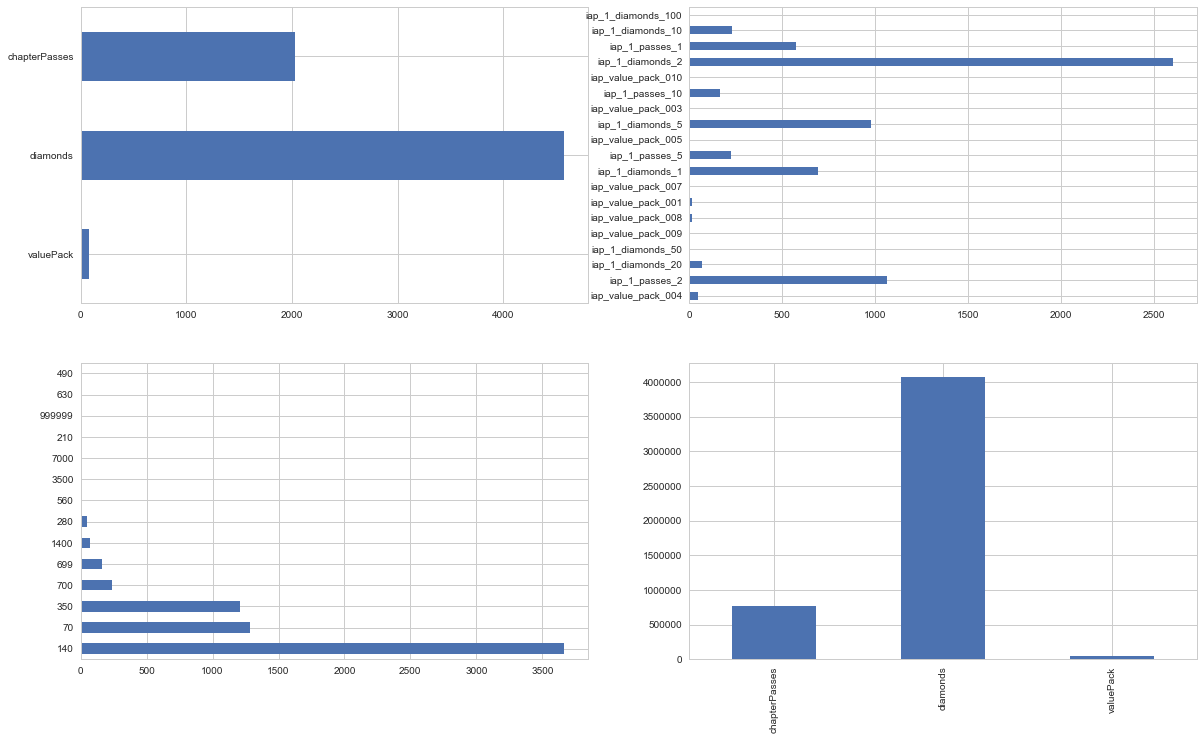

In [225]:
fig, ax = plt.subplots(2, 2, figsize=[20, 12])
iaps['prod_type'].value_counts(sort = False).plot(kind ='barh', ax = ax[0][0])
iaps['prod_name'].value_counts(sort = False).plot(kind ='barh', ax = ax[0][1])
iaps['rev'].value_counts(sort = True).plot(kind='barh', ax = ax[1][0])
agg_iap_spending.plot.bar(ax = ax[1][1])

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#sns.set(style="whitegrid")
#sns.set_color_codes("pastel")
#sns.barplot(data=pivot_price,
#            label="Total", color="b")

# 3. Spend events

### a. Time features

In [63]:
spendevents['ts_spend'] = pd.to_datetime(spendevents['ts'], infer_datetime_format=True)
spendevents['ts_dayofweek'] = spendevents['ts_spend'].apply(lambda x: x.dayofweek)
spendevents['ts_dayofyear'] = spendevents['ts_spend'].apply(lambda x: x.dayofyear)
spendevents['ts_weekofyear'] = spendevents['ts_spend'].apply(lambda x: x.weekofyear)
spendevents['ts_hour'] = spendevents['ts_spend'].apply(lambda x: x.hour)
spendevents.head(1)

### b. Sum spending by week

In [205]:
spend_w = pd.pivot_table(spendevents,index=["udid"],\
                               values=["amount"],columns=["ts_weekofyear"],\
                               aggfunc=[np.sum],fill_value=0,margins=True)
spend_w = pd.DataFrame(spend_w.to_records())
spend_w.columns = [i.replace("('sum', 'amount', ", "s-week").replace(")", "") \
for i in spend_w.columns]
agg_spend_w = spend_w.mean(axis=0).drop("s-week'All'")
agg_spend_w

s-week31    -569.060939
s-week32   -1110.530137
s-week33      -0.158508
s-week34      -0.043734
s-week35      -0.089244
s-week36       0.007215
s-week37      -0.193806
s-week38      -0.008658
s-week39       0.014652
s-week40       0.000999
dtype: float64

### c. Sum spending by categories

In [207]:
spend_sum1 = pd.pivot_table(spendevents,index=["udid"],\
                               values=["amount"],columns=["spendtype"],\
                               aggfunc=[np.sum],fill_value=0,margins=True)
spend_sum1 = pd.DataFrame(spend_sum1.to_records())
spend_sum1.columns = [i.replace("('sum', 'amount', '", "").replace("')", "") \
                     for i in spend_sum1.columns]
spend_sum1.head(3)

,udid,IAP,earnDiamondsCounter,premiumChoice,valuepack,All
0,0001098a82ba4bd5b552faf5ad92b93c,0.0,-12.0,12.0,0.0,0.0
1,00012dc580694209acc53386fafaf745,0.0,-10.0,0.0,0.0,-10.0
2,00015af3b03042ceb45d3c58b416a8ce,0.0,-5.0,0.0,0.0,-5.0


### D. Graphics: Compare sessions activities with spending & iap spendings

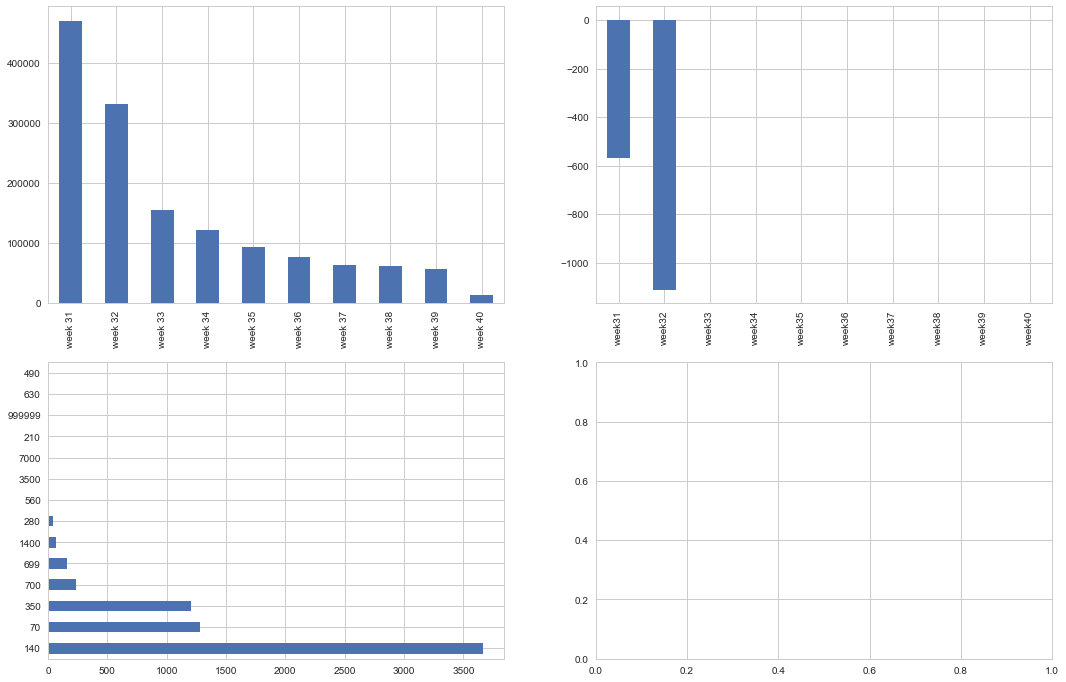

In [192]:
fig, ax = plt.subplots(2, 2, figsize=[18, 12])
agg_w.plot.bar(ax = ax[0][0])
agg_spend_w.plot.bar(ax = ax[0][1])
iaps['rev'].value_counts(sort = True).plot(kind='barh', ax = ax[1][0])

### e. Graphics: spending in story and chapters

In [142]:
spendevents['amount'].value_counts().head(5)

 0    38468
-5    27348
-1    12083
-2     9324
 8     3439
Name: amount, dtype: int64

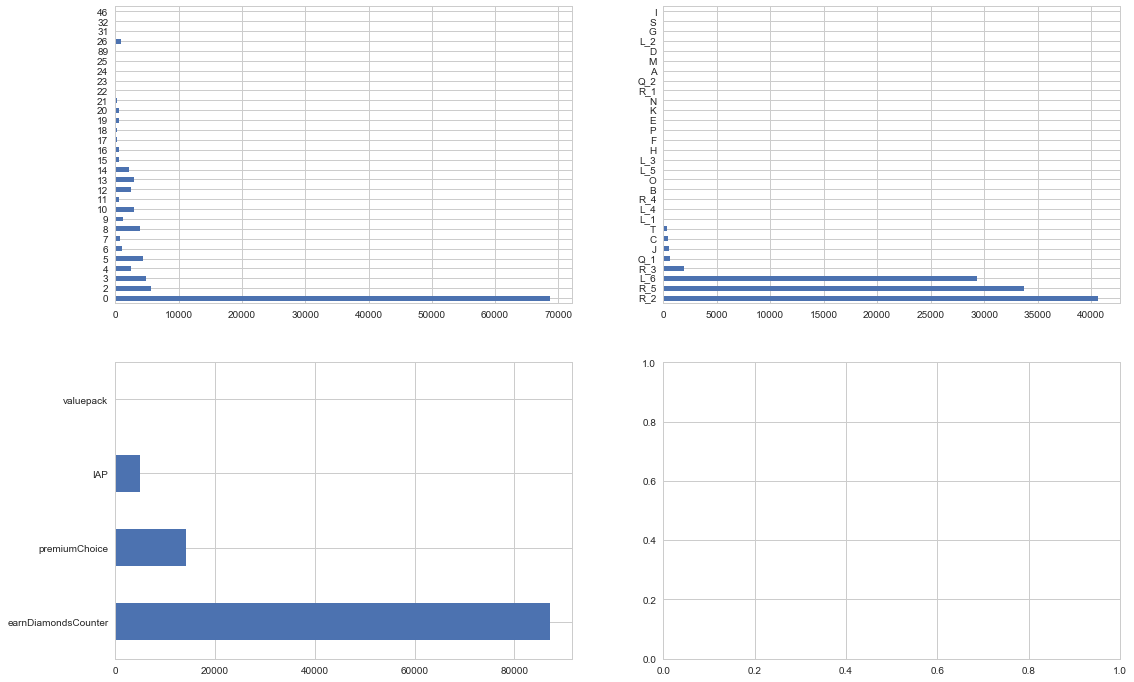

In [193]:
Fig, ax = plt.subplots(2,2,figsize=[18,12])
spendevents['chapter'].value_counts(sort = False).plot(kind='barh', ax=ax[0][0])
spendevents['spendtype'].value_counts().plot(kind='barh', ax=ax[1][0])
spendevents['story'].value_counts().plot(kind = 'barh', ax=ax[0][1])

# 4. Users

In [147]:
users.head(1)

,udid,install_date,lang,country,hw_ver,os_ver
0,88258a36ad1447c4b407bb782c9f7f39,8/1/16,th,TH,"iPhone6,2",9.2.1


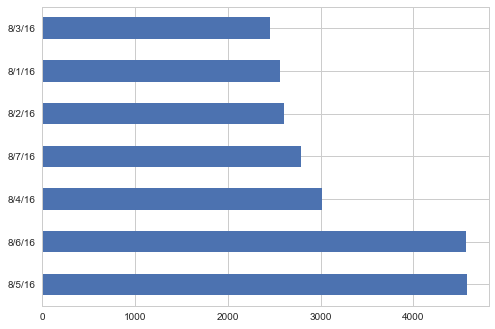

In [148]:
users.install_date.value_counts().plot('barh')

In [249]:
spend_sum2 = spendevents.groupby('udid')['amount'].agg([len, np.sum, np.mean, np.max, np.min]).reset_index()
spend_sum2.columns = ['udid','spend_times','spend_sum','spend_mean','spend_max','spend_min']
mergespend_iap = pd.merge(spend_sum1,iap_sum2, how='left',on='udid')
mergespend_iap = pd.merge(mergespend_iap,spend_sum2, how='left',on='udid')
feature_sum = pd.merge(sessions_feature,mergespend_iap, how = 'left',on = 'udid')

In [253]:
len(feature_sum)

22544

In [252]:
feature_sum.isnull().sum()

udid                               0
len                                0
total_active_sessions              0
amin                               0
amax                               0
length                             0
frequency                          0
frequency_type                     0
length_type                        0
IAP                             4547
earnDiamondsCounter             4547
premiumChoice                   4547
valuepack                       4547
All                             4547
iap_spendtime_chapterPasses    21069
iap_spendtime_diamonds         21069
iap_spendtime_valuePack        21069
iap_spendtime_All              21069
spend_times                     4547
spend_sum                       4547
spend_mean                      4547
spend_max                       4547
spend_min                       4547
dtype: int64

In [250]:
feature_sum
print(feature_sum.iloc[0:10,1:10])
print(feature_sum.iloc[0:10,11:20])
print(feature_sum.iloc[0:10,21:30])

   len total_active_sessions  amin  amax  length  frequency  \
0   44    more than 30 times   215   246      31   1.419355   
1   32    more than 30 times   218   233      15   2.133333   
2    3    less than 10 times   218   218       0   0.010000   
3   99    more than 30 times   218   272      54   1.833333   
4    1         one time user   218   218       0   0.010000   
5    1         one time user   217   217       0   0.010000   
6    8    less than 10 times   220   220       0   0.010000   
7    2    less than 10 times   215   217       2   1.000000   
8    1         one time user   214   214       0   0.010000   
9    4    less than 10 times   217   217       0   0.010000   

             frequency_type       length_type   IAP  
0  active 0.6-3 times a day     24 to 60 days   0.0  
1  active 0.6-3 times a day      3 to 24 days   0.0  
2                  inactive           one day   0.0  
3  active 0.6-3 times a day     24 to 60 days -22.0  
4                  inactive         